In [1]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2 as cv
import random
import imageio
import os

In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## Data Processing

In [3]:
# some hyperparameters for data processing
IMG_HEIGHT = 120
IMG_WIDTH = 300
SEQUENCE_LENGTH = 200
DATASET_DIR = "/Users/mariakrylova/Documents/ZaVod/data/Datasets/cutted"
CLASSES_LIST = ['Dyslexia', 'Normal', 'Risk']

**Resizing and Normalizing videos**

In [4]:
def frame_normalizer(path):
    frames_l = []
    cap = cv.VideoCapture(path)
    if (cap.isOpened()== False): 
        print("Error opening video stream or file")
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:
            resized_frame = cv.resize(frame, (IMG_WIDTH, IMG_HEIGHT))
            normalized_frame = resized_frame / 255
            #print(normalized_frame.shape)
            frames_l.append(normalized_frame)
        else:
            break
    cap.release()
    return frames_l

**Dataset creation**

In [5]:
def dataset_creation():
    features = []
    labels = []
    pathes = []
    for idx, class_name in enumerate(CLASSES_LIST):
        path = os.path.join(DATASET_DIR, class_name)
        files = os.listdir(path)
        for file in files:
            if file != ".DS_Store":
                video_path = os.path.join(path, file)
                frames = frame_normalizer(video_path)[:SEQUENCE_LENGTH]
                if len(frames) == SEQUENCE_LENGTH: 
                    features.append(frames)
                    labels.append(idx)
                    pathes.append(video_path)
    features = np.asarray(features)
    labels = np.array(labels)
    return features, labels, pathes

In [6]:
features, labels, pathes = dataset_creation()

In [7]:
from keras.utils import to_categorical
one_hot_labels = to_categorical(labels)

In [8]:
#splitting to train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, one_hot_labels, test_size=0.1, 
                                                    stratify=labels, random_state=seed_constant, shuffle=True)

## ConvLSTM NN

In [9]:
from keras.layers import *
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras_tuner import BayesianOptimization, HyperModel

**Architecture example**

In [22]:
def convlstm_model_creation():
    model = Sequential()
    model.add(ConvLSTM2D(filters=4, kernel_size=(3,3), activation='relu', data_format='channels_last',
                         recurrent_dropout=0.2, return_sequences=True, input_shape=(SEQUENCE_LENGTH, IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
    model.add(Flatten())
    model.add(Dense(len(CLASSES_LIST), activation='Softmax'))
    model.summary()
    return model

In [12]:
convlstm_model = convlstm_model_creation()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 200, 118, 298, 4   1024      
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 200, 59, 149, 4)   0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 7032800)           0         
                                                                 
 dense (Dense)               (None, 3)                 21098403  
                                                                 
Total params: 21099427 (80.49 MB)
Trainable params: 21099427 (80.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/7
8/8 [==============================] - 157s 19s/step - loss: 2649.0469 - accuracy: 0.2500 - val_loss: 3227.8994 - val_accuracy: 0.3750
Epoch 2/7
8/8 [==============================] - 147s 18s/step - loss: 1154.2533 - accuracy: 0.4375 - val_loss: 136.1737 - val_accuracy: 0.1250
Epoch 3/7
8/8 [==============================] - 138s 17s/step - loss: 579.1815 - accuracy: 0.3438 - val_loss: 168.7845 - val_accuracy: 0.3750
Epoch 4/7
8/8 [==============================] - 134s 17s/step - loss: 254.2395 - accuracy: 0.3125 - val_loss: 226.5894 - val_accuracy: 0.1250
Epoch 5/7
8/8 [==============================] - 136s 17s/step - loss: 142.0565 - accuracy: 0.3750 - val_loss: 50.4287 - val_accuracy: 0.1250
Epoch 6/7
8/8 [==============================] - 137s 17s/step - loss: 148.9450 - accuracy: 0.4062 - val_loss: 39.0182 - val_accuracy: 0.1250
Epoch 7/7
8/8 [==============================] - 135s 17s/step - loss: 109.5880 - accuracy: 0.5312 - val_loss: 35.8703 - val_accuracy: 0.5000

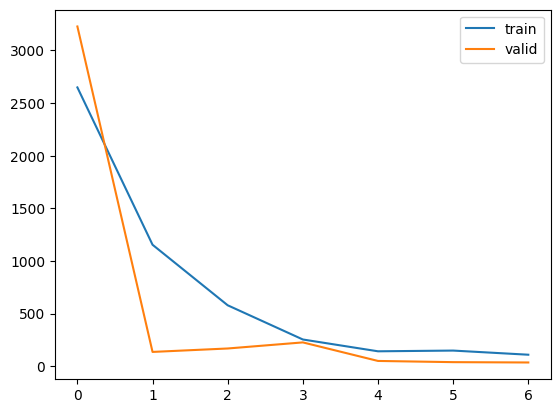

In [14]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)
convlstm_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

history = convlstm_model.fit(X_train, y_train, epochs=7, batch_size=4, 
                             shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

In [16]:
score = convlstm_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 70.0687484741211
Test accuracy: 0.20000000298023224


In [20]:
convlstm_model.save('/Users/mariakrylova/Documents/ZaVod/codes/convLstm7')

INFO:tensorflow:Assets written to: /Users/mariakrylova/Documents/ZaVod/codes/convLstm7/assets


INFO:tensorflow:Assets written to: /Users/mariakrylova/Documents/ZaVod/codes/convLstm7/assets


**Tuning our model**

In [10]:
class ConvLSTMHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(ConvLSTM2D(filters=hp.Int('filters',
                                          min_value=4,
                                          max_value=16,
                                          step=4), 
                            kernel_size=(3,3), 
                            activation=hp.Choice('activation',
                                                values=['relu', 'tanh', 'sigmoid', 'exponential']), 
                            data_format='channels_last',
                            recurrent_dropout=0.2, 
                            return_sequences=True, 
                            input_shape=(SEQUENCE_LENGTH, IMG_HEIGHT, IMG_WIDTH, 3)))
        model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
        model.add(Flatten())
        model.add(Dense(len(CLASSES_LIST), activation='Softmax'))
        model.compile(loss='categorical_crossentropy', 
                            optimizer=hp.Choice('optimizer',
                                               values=['adam', 'SGD', 'rmsprop']), 
                             metrics=['accuracy'])
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Int("batch_size",
                              min_value=2,
                              max_value=6,
                              step=2),
            epochs=hp.Int("epochs",
                          min_value=2,
                          max_value=4,
                          step=1
            ),
            **kwargs,
        )

In [11]:
tuner = BayesianOptimization(
    ConvLSTMHyperModel(),
    objective='val_accuracy',
    max_trials=3,
    overwrite=True,
    directory='/Users/mariakrylova/Documents/ZaVod/codes/models',
    project_name="tune_hypermodel",
)

In [12]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
filters (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 16, 'step': 4, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid', 'exponential'], 'ordered': False}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'SGD', 'rmsprop'], 'ordered': False}


In [13]:
tuner.search(
    X_train,
    y_train,
    validation_split=0.2,
    verbose=1,
    callbacks=[keras.callbacks.EarlyStopping('val_loss', patience=2)]
)

Trial 3 Complete [00h 03m 43s]
val_accuracy: 0.125

Best val_accuracy So Far: 0.375
Total elapsed time: 00h 13m 13s
INFO:tensorflow:Oracle triggered exit


In [14]:
tuner.results_summary()

Results summary
Results in /Users/mariakrylova/Documents/ZaVod/codes/models/tune_hypermodel
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
filters: 4
activation: sigmoid
optimizer: rmsprop
batch_size: 2
epochs: 2
Score: 0.375

Trial 1 summary
Hyperparameters:
filters: 4
activation: relu
optimizer: adam
batch_size: 4
epochs: 2
Score: 0.375

Trial 2 summary
Hyperparameters:
filters: 4
activation: relu
optimizer: SGD
batch_size: 6
epochs: 2
Score: 0.125


In [15]:
models = tuner.get_best_models(num_models=3)
for model in models:
    model.summary()
    model.evaluate(X_test, y_test)
    print()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 200, 118, 298, 4   1024      
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 200, 59, 149, 4)   0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 7032800)           0         
                                                                 
 dense (Dense)               (None, 3)                 21098403  
                                                                 
Total params: 21099427 (80.49 MB)
Trainable params: 21099427 (80.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
1/1 [=========